In [1]:
import sys
sys.path.insert(1, '../')

from river import stream,tree,metrics
from encoding import prefix_bin
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

import os,json
import datetime
from collections import deque, Counter
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import datetime, time
import utils
import sliding_window
import psutil

import copy
import gzip
from tqdm import tqdm

In [2]:
import gzip
import pickle as pkl
import os
import encodings

In [3]:
def get_acc_f1(records):
    key = list(records.keys())[-1]
    f1_score_array =[]
    accuracy_array = []
    for u in records[key].keys():
        y_true_array = []
        y_pred_array = []

        for i in records[key][u]['y_true']:
            if i =='True':
                y_true_array.append(True)
            else:
                y_true_array.append(False)
                
        for pos, i in enumerate(records[key][u]['y_pred']):
            if len(i[0]) ==1 and pos !=0:
    
                records[key][u]['y_pred'][pos] = records[key][u]['y_pred'][pos-1]
            elif len(i[0]) ==1 and pos == 0:
                records[key][u]['y_pred'][pos] = [[1, 0]]
                
        for pos, i in enumerate(records[key][u]['y_pred']):
            if i[0][0] < i[0][1]:
                pred = True
            else:
                pred = False
            y_pred_array.append(pred)
    #     print(classification_report(y_true_array, y_pred_array))
        accuracy_array.append(accuracy_score(y_true_array, y_pred_array))
        f1_score_array.append(f1_score(y_true_array, y_pred_array, average='weighted'))   
    
    return accuracy_array, f1_score_array

In [4]:
def hatc_get_acc_f1(records):
    key = list(records.keys())[-1]
    f1_score_array =[]
    accuracy_array = []
    for u in records[key].keys():
        y_true_array = []
        y_pred_array = []

        for i in records[key][u]['y_true']:
            if i =='True':
                y_true_array.append(True)
            else:
                y_true_array.append(False)
        for i in records[key][u]['y_pred']:
            if 'True' not in i.keys():
                i['True'] = 0
            elif 'False' not in i.keys():
                i['False'] = 0
        
            if i['False'] < i['True']:
                pred = True
            else:
                pred = False
            y_pred_array.append(pred)
    #     print(classification_report(y_true_array, y_pred_array))
        accuracy_array.append(accuracy_score(y_true_array, y_pred_array))
        f1_score_array.append(f1_score(y_true_array, y_pred_array, average='weighted'))   
    
    return accuracy_array, f1_score_array

In [5]:
result_dict = {}
for dataset_label in ['bpic2011_1','bpic2011_3','bpic2011_4','bpic2015_1','bpic2015_2','bpic2015_3','bpic2015_4','bpic2015_5',
                      'Production_Data','sepsis_cases_1','sepsis_cases_2','sepsis_cases_3','traffic_fines_1','hospital_billing_1',
                      'hospital_billing_2','bpic2012_1', 'bpic2012_2', 'bpic2012_3','bpic2017_1','bpic2017_2','bpic2017_3','IRO5K' ,
                      'OIR5K']:
# for dataset_label in ['bpic2015_5']:
    classifier = 'xgb'
    print(dataset_label)
    with open('../dataset_parameters.json','r') as json_file:
        parameters = json.load(json_file)[dataset_label]
        key_pair = parameters['key_pair']
        catatars = parameters['categorical_attrs']
        maximum_prefixs = parameters['maximum_prefix']
        prefix_range = parameters['prefix']
        
    for prefix in prefix_range:

        result_dict[(classifier, dataset_label, prefix)] ={}
        result_dict[(classifier, dataset_label, prefix)] ={}
        result_dict[(classifier, dataset_label, prefix)] ={}
        
        train_once_loc =  '../result/%s/%s/Finished cases/Train once/prefix_%s update.pkl'%(dataset_label, classifier, str(prefix))
        retrain_variant_loc = '../result/%s/%s/Finished cases/Trigger variant/prefix_%s update retrained.pkl'%(dataset_label, classifier, str(prefix))
        retrain_label_loc = '../result/%s/%s/Finished cases/Trigger label/prefix_%s update retrained.pkl'%(dataset_label, classifier, str(prefix))
        retrain_prodrift_loc = '../result/%s/%s/Finished cases/Trigger prodrift/prefix_%s update retrained.pkl'%(dataset_label, classifier, str(prefix))
        retrain_prefixtreeCDD_loc = '../result/%s/%s/Finished cases/Trigger prefixtreeCDD/prefix_%s update retrained.pkl'%(dataset_label, classifier, str(prefix))
        with gzip.open(train_once_loc) as f:
            train_once = pkl.loads(f.read())
        with gzip.open(retrain_variant_loc) as f:
            retrain_variant = pkl.loads(f.read())
        with gzip.open(retrain_label_loc) as f:
            retrain_label = pkl.loads(f.read())
        with gzip.open(retrain_prodrift_loc) as f:
            retrain_prodrift = pkl.loads(f.read())
        with gzip.open(retrain_prefixtreeCDD_loc) as f:
            retrain_prefixtreeCDD = pkl.loads(f.read())
             
        if classifier == 'hatc':            
            train_once_acc, train_once_f1 = hatc_get_acc_f1(train_once)
            retrain_variant_acc, retrain_variant_f1 = hatc_get_acc_f1(retrain_variant)
            retrain_label_acc, retrain_label_f1 = hatc_get_acc_f1(retrain_label)
            retrain_prodrift_acc, retrain_prodrift_f1 = hatc_get_acc_f1(retrain_prodrift)
            retrain_prefixtreeCDD_acc, retrain_prefixtreeCDD_f1 = hatc_get_acc_f1(retrain_prefixtreeCDD)

        else:
            train_once_acc, train_once_f1 = get_acc_f1(train_once)
            retrain_variant_acc, retrain_variant_f1 = get_acc_f1(retrain_variant)
            retrain_label_acc, retrain_label_f1 = get_acc_f1(retrain_label)
            retrain_prodrift_acc, retrain_prodrift_f1 = get_acc_f1(retrain_prodrift)
            retrain_prefixtreeCDD_acc, retrain_prefixtreeCDD_f1 = get_acc_f1(retrain_prefixtreeCDD)
            
#         print('Train once')
#         print('Acc :', round(np.average(train_once_acc),3), round(np.std(train_once_acc),3))
#         print('F1 :', round(np.average(train_once_f1),3), round(np.std(train_once_f1),3))

#         print('Retrain variant')
#         print('Acc :', round(np.average(retrain_variant_acc),3), round(np.std(retrain_variant_acc),3))
#         print('F1 :', round(np.average(retrain_variant_f1),3), round(np.std(retrain_variant_f1),3))

        result_dict[(classifier, dataset_label, prefix)]['Train once F1 (Avg.)'] = round(np.average(train_once_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain variant F1 (Avg.)'] = round(np.average(retrain_variant_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain label F1 (Avg.)'] = round(np.average(retrain_label_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain prodrift F1 (Avg.)'] = round(np.average(retrain_prodrift_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain prefixtreeCDD F1 (Avg.)'] = round(np.average(retrain_prefixtreeCDD_f1),3)

        # a = [np.average(train_once_f1), np.average(retrain_variant_f1), np.average(retrain_label_f1), np.average(retrain_prodrift_f1), np.average(retrain_prefixtreeCDD_f1)]
        # print(max(a), a.index(max(a)))
         
        result_dict[(classifier, dataset_label, prefix)]['Train once Acc (Avg.)'] = round(np.average(train_once_acc),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain variant Acc (Avg.)'] = round(np.average(retrain_variant_acc),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain label Acc (Avg.)'] = round(np.average(retrain_label_acc),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain prodrift Acc (Avg.)'] = round(np.average(retrain_prodrift_acc),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain prefixtreeCDD Acc (Avg.)'] = round(np.average(retrain_prefixtreeCDD_acc),3)

        result_dict[(classifier, dataset_label, prefix)]['Train once F1 (Std.)'] = round(np.std(train_once_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain variant F1 (Std.)'] = round(np.std(retrain_variant_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain label F1 (Std.)'] = round(np.std(retrain_label_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain prodrift F1 (Std.)'] = round(np.std(retrain_prodrift_f1),3)
        result_dict[(classifier, dataset_label, prefix)]['Retrain prefixtreeCDD F1 (Std.)'] = round(np.std(retrain_prefixtreeCDD_f1),3)

        # result_dict[(classifier, dataset_label, prefix)]['Train once Acc (Std.)'] = round(np.std(train_once_acc),3)
        # result_dict[(classifier, dataset_label, prefix)]['Retrain variant Acc (Std.)'] = round(np.std(retrain_variant_acc),3)
        # result_dict[(classifier, dataset_label, prefix)]['Retrain label Acc (Std.)'] = round(np.std(retrain_label_acc),3)
        # result_dict[(classifier, dataset_label, prefix)]['Retrain prodrift Acc (Std.)'] = round(np.std(retrain_prodrift_acc),3)

        print('--------------------')


bpic2011_1
--------------------



KeyboardInterrupt



In [80]:
df = pd.DataFrame.from_dict(result_dict).T
df.index.values
# file_name = '../result/Comparison/%s_acc_result.csv'%(classifier)
# df.to_csv(file_name)
# print(file_name)

array([('xgb', 'bpic2011_1', 10), ('xgb', 'bpic2011_1', 19),
       ('xgb', 'bpic2011_1', 27), ('xgb', 'bpic2011_3', 9),
       ('xgb', 'bpic2011_3', 16), ('xgb', 'bpic2011_3', 24),
       ('xgb', 'bpic2011_4', 11), ('xgb', 'bpic2011_4', 21),
       ('xgb', 'bpic2011_4', 30), ('xgb', 'bpic2015_1', 11),
       ('xgb', 'bpic2015_1', 21), ('xgb', 'bpic2015_1', 30),
       ('xgb', 'bpic2015_2', 11), ('xgb', 'bpic2015_2', 21),
       ('xgb', 'bpic2015_2', 30), ('xgb', 'bpic2015_3', 11),
       ('xgb', 'bpic2015_3', 21), ('xgb', 'bpic2015_3', 30),
       ('xgb', 'bpic2015_4', 11), ('xgb', 'bpic2015_4', 21),
       ('xgb', 'bpic2015_4', 30), ('xgb', 'bpic2015_5', 11),
       ('xgb', 'bpic2015_5', 21), ('xgb', 'bpic2015_5', 30),
       ('xgb', 'Production_Data', 7), ('xgb', 'Production_Data', 12),
       ('xgb', 'Production_Data', 18), ('xgb', 'sepsis_cases_1', 8),
       ('xgb', 'sepsis_cases_1', 16), ('xgb', 'sepsis_cases_1', 23),
       ('xgb', 'sepsis_cases_2', 4), ('xgb', 'sepsis_cases_2'

In [81]:
df.columns.values

array(['Train once F1 (Avg.)', 'Retrain variant F1 (Avg.)',
       'Retrain label F1 (Avg.)', 'Retrain prodrift F1 (Avg.)',
       'Retrain prefixtreeCDD F1 (Avg.)', 'Train once Acc (Avg.)',
       'Retrain variant Acc (Avg.)', 'Retrain label Acc (Avg.)',
       'Retrain prodrift Acc (Avg.)', 'Retrain prefixtreeCDD Acc (Avg.)',
       'Train once F1 (Std.)', 'Retrain variant F1 (Std.)',
       'Retrain label F1 (Std.)', 'Retrain prodrift F1 (Std.)',
       'Retrain prefixtreeCDD F1 (Std.)'], dtype=object)

In [82]:
avg_col_list = []
for i in df.columns.values:
    if 'Avg.' in i and 'Acc' in i:
        avg_col_list.append(i)
df = df.loc[:, avg_col_list]
df = df.loc[:, avg_col_list].to_csv('../result/Comparison/%s_acc_result.csv'%(classifier))

In [83]:
df

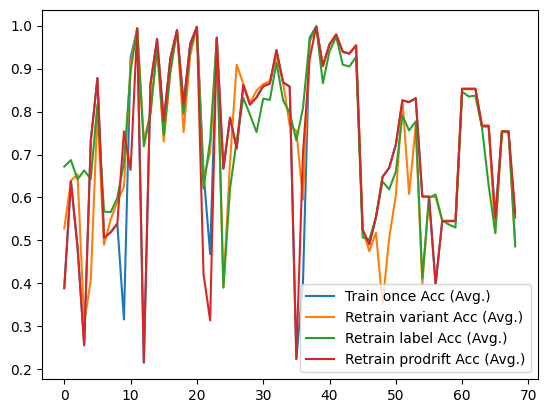

In [63]:
for i in df.columns.values:
    if 'Avg.' in i and 'Acc' in i:
        plt.plot(list(df.loc[:,i]), label = i)
plt.legend()
plt.show()

In [109]:
retraining_condition = 'prefixtreeCDD'

notyet =[] 
for dataset_label in ['bpic2011_1','bpic2011_3','bpic2011_4','bpic2015_1','bpic2015_2','bpic2015_3','bpic2015_4','bpic2015_5',
                      'Production_Data','sepsis_cases_1','sepsis_cases_2','sepsis_cases_3','traffic_fines_1','hospital_billing_1',
                      'hospital_billing_2','bpic2012_1', 'bpic2012_2', 'bpic2012_3','bpic2017_1','bpic2017_2','bpic2017_3','IRO5K' ,
                      'OIR5K']:
    with open('../dataset_parameters.json','r') as json_file:
        parameters = json.load(json_file)[dataset_label]
        key_pair = parameters['key_pair']
        catatars = parameters['categorical_attrs']
        prefix_range = parameters['prefix']
        # prefix_range = [prefix_range[-1]]
    for classifier in ['lstm']:
        for prefix in prefix_range:
            retrain_label_loc = '../result/%s/%s/Finished cases/Trigger %s/prefix_%s update retrained.pkl'%(dataset_label, classifier, retraining_condition, prefix)

            # training_time_ls = '../result/time/%s_%s_%s_%s_trainingtime.pkl'%(dataset_label, classifier, prefix, retraining_condition)
            try:            
                with gzip.open(retrain_label_loc) as f:
                    retrain_variant = pkl.loads(f.read())
            except:
                print(retrain_label_loc)
                notyet.append(retrain_label_loc)
                pass
print(len(notyet))

0


In [5]:
### checking time
result_dict = {}
retraining_condition = 'label'
for dataset_label in ['bpic2011_1','bpic2011_3','bpic2011_4','bpic2015_1','bpic2015_2','bpic2015_3','bpic2015_4','bpic2015_5',
                      'Production_Data','sepsis_cases_1','sepsis_cases_2','sepsis_cases_3','traffic_fines_1','hospital_billing_1',
                      'hospital_billing_2','bpic2012_1', 'bpic2012_2', 'bpic2012_3','bpic2017_1','bpic2017_2','bpic2017_3','IRO5K' ,
                      'OIR5K']:
    with open('../dataset_parameters.json','r') as json_file:
        parameters = json.load(json_file)[dataset_label]
        key_pair = parameters['key_pair']
        catatars = parameters['categorical_attrs']
        prefix_range = parameters['prefix']
        # prefix_range = [prefix_range[-1]]
    for classifier in ['HATC', 'RF','XGB', 'LSTM']:
        for prefix in prefix_range:

            training_time_ls = '../result/time/%s_%s_%s_%s_trainingtime.pkl'%(dataset_label, classifier, prefix, retraining_condition)
            try:            
                with gzip.open(training_time_ls) as f:
                    retrain_variant = pkl.loads(f.read())

                mean = (np.average(retrain_variant))
                sd = np.std(retrain_variant)
                # print(round(mean,2), round(sd,2))
    
                result_dict[(classifier, dataset_label, prefix)] ={'Average Training Time':0, 'Std. Training time':0,'Update Frequency':0}
                result_dict[(classifier, dataset_label, prefix)]['Average Training Time'] = round(mean, 3)
                result_dict[(classifier, dataset_label, prefix)]['Std. Training time'] = round(sd, 3)
                result_dict[(classifier, dataset_label, prefix)]['Update Frequency'] = len(retrain_variant)
                # print(dataset_label, prefix, classifier)
            except:
                print(training_time_ls)
                pass
            
    

../result/time/bpic2011_1_LSTM_10_label_trainingtime.pkl
../result/time/bpic2011_1_LSTM_19_label_trainingtime.pkl
../result/time/bpic2011_1_LSTM_27_label_trainingtime.pkl
../result/time/bpic2011_3_LSTM_9_label_trainingtime.pkl
../result/time/bpic2011_3_LSTM_16_label_trainingtime.pkl
../result/time/bpic2011_3_LSTM_24_label_trainingtime.pkl
../result/time/bpic2011_4_HATC_30_label_trainingtime.pkl
../result/time/bpic2011_4_LSTM_11_label_trainingtime.pkl
../result/time/bpic2011_4_LSTM_21_label_trainingtime.pkl
../result/time/bpic2011_4_LSTM_30_label_trainingtime.pkl
../result/time/bpic2015_1_LSTM_11_label_trainingtime.pkl
../result/time/bpic2015_1_LSTM_21_label_trainingtime.pkl
../result/time/bpic2015_1_LSTM_30_label_trainingtime.pkl
../result/time/bpic2015_2_LSTM_11_label_trainingtime.pkl
../result/time/bpic2015_2_LSTM_21_label_trainingtime.pkl
../result/time/bpic2015_2_LSTM_30_label_trainingtime.pkl
../result/time/bpic2015_4_LSTM_30_label_trainingtime.pkl
../result/time/bpic2015_5_LSTM_1

In [6]:
df = pd.DataFrame.from_dict(result_dict).T
df.index.values
file_name = '../result/Comparison/training_time.csv'
dfs = df.reset_index(drop=False)
dfs = dfs.rename(columns={'level_0':'Classifier', 'level_1':'Event log','level_2':'Prefix'})
# dfs.to_csv(file_name, index=False)
# print(df.columns.values)
# print(file_name)

In [7]:
dfs

,Classifier,Event log,Prefix,Average Training Time,Std. Training time,Update Frequency
0,HATC,bpic2011_1,10,3.244,0.559,76.0
1,HATC,bpic2011_1,19,7.061,1.528,90.0
2,HATC,bpic2011_1,27,6.779,1.177,50.0
3,RF,bpic2011_1,10,0.027,0.006,84.0
4,RF,bpic2011_1,19,0.034,0.023,95.0
...,...,...,...,...,...,...
230,XGB,OIR5K,7,0.040,0.015,32.0
231,XGB,OIR5K,10,0.035,0.000,1.0
232,LSTM,OIR5K,4,2.633,0.782,32.0
233,LSTM,OIR5K,7,2.095,0.765,32.0


In [8]:
import matplotlib.pyplot as plt

groups = dfs.groupby('Classifier')
avg_train_time = {}
std_train_time = {}
classifiers=  ['HATC', 'RF', 'XGB', 'LSTM']

for _, group in groups:
    # print(group['Update Frequency'])
    avg_train_time[_] = group['Average Training Time']
    std_train_time[_] = group['Std. Training time']
avg_time_comp = []
std_time_comp = []

for i in classifiers:
    print(len(avg_train_time[i]))
    print(i, np.mean(avg_train_time[i]))
    avg_time_comp.append(np.mean(avg_train_time[i]))
    std_time_comp.append(np.std(std_train_time[i]))

68
HATC 3.4531176470588236
69
RF 0.03108695652173913
69
XGB 0.18134782608695652
29
LSTM 7.623379310344829


In [9]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

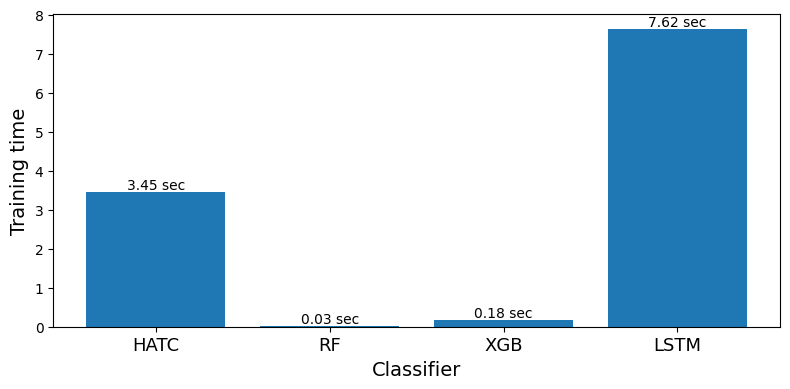

In [14]:
# color = ['lightblue', 'blue', 'purple', 'red', 'black']
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
bar_container = ax.bar(classifiers, [round(i,2) for i in avg_time_comp])

ax.set_ylabel('Training time', fontsize = 14)
ax.set_xlabel('Classifier', fontsize = 14)
ax.xaxis.set_tick_params(labelsize=13)

ax.bar_label(bar_container, fmt=lambda x: f'{x} sec')
# addlabels(avg_train_time.keys(), [round(i, 2) for i in avg_time_comp],  fmt=lambda x: f'{x * 1.61:.1f} km/h')
plt.tight_layout()
# plt.title('Comparison of Average Training Time Across Classifiers')
# plt.show()
plt.savefig('../imgs/Comparison of Average Training Time Across Classifiers.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Std. training time by classifiers')

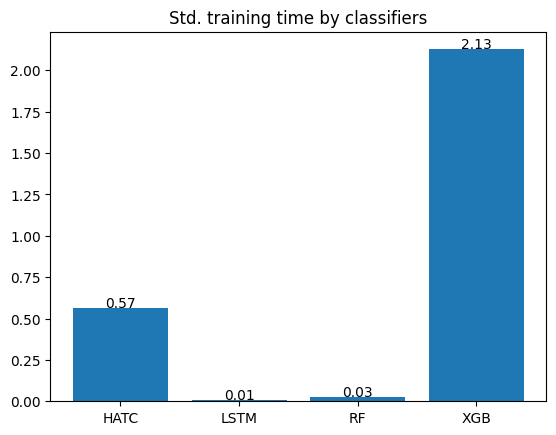

In [98]:
# color = ['lightblue', 'blue', 'purple', 'red', 'black']
plt.bar(std_train_time.keys(), std_time_comp)
addlabels(std_train_time.keys(), [round(i, 2) for i in std_time_comp])

plt.title('Std. training time by classifiers')

In [16]:
def count_updates(data):
    truen = 0
    falsen = 0
    for i in data:
        if data[i] == True:
            truen +=1
        else:
            falsen +=1
    result = dict()
    result['True'] = truen
    result['False'] = falsen
    return result

In [17]:
def trigger_cd(dataset_label, cd_type):
    file_path = '../triggered_cd/%s/%s_CD_list.pkl'%(cd_type, dataset_label)
    with open(file_path, 'rb') as f:
        data = pkl.load(f)
    return data

In [18]:
count = 0
update_freq ={}
classifier = 'rf'
for dataset_label in ['bpic2011_1','bpic2011_3','bpic2011_4','bpic2015_1','bpic2015_2','bpic2015_3','bpic2015_4','bpic2015_5',
                      'Production_Data','sepsis_cases_1','sepsis_cases_2','sepsis_cases_3','traffic_fines_1','hospital_billing_1',
                      'hospital_billing_2','bpic2012_1', 'bpic2012_2', 'bpic2012_3','bpic2017_1','bpic2017_2','bpic2017_3','IRO5K' ,
                      'OIR5K']:
    with open('../dataset_parameters.json','r') as json_file:
        parameters = json.load(json_file)[dataset_label]
        key_pair = parameters['key_pair']
        catatars = parameters['categorical_attrs']
        prefix_range = parameters['prefix']
    
    for prefix in prefix_range:
        update_freq[(classifier, dataset_label, prefix)] ={}
        file_path = '../result/%s/rf/Finished cases/Trigger label/prefix_%s retrained_test_window_check.pkl'%(dataset_label, prefix)
        with gzip.open(file_path ,'rb') as f:
            data_label = pkl.loads(f.read())
        
        file_path = '../result/time/%s_rf_%s_variant_trainingtime.pkl'%(dataset_label, prefix)

        with gzip.open(file_path ,'rb') as f:
            data_variant = pkl.loads(f.read())
        update_freq[(classifier, dataset_label, prefix)]['Variant'] = len(data_variant)
        update_freq[(classifier, dataset_label, prefix)]['Label Dist.'] = count_updates(data_label)['True']
        update_freq[(classifier, dataset_label, prefix)]['Prodrift'] = len(trigger_cd(dataset_label, 'prodrift'))
        update_freq[(classifier, dataset_label, prefix)]['prefixtreeCDD'] = len(trigger_cd(dataset_label, 'prefixtreeCDD'))

In [19]:
df = pd.DataFrame.from_dict(update_freq).T
df.index.values
file_name = '../result/Comparison/training_time.csv'
dfs = df.reset_index(drop=False)
dfs = dfs.rename(columns={'level_0':'Classifier', 'level_1':'Event log','level_2':'Prefix'})
# dfs.to_csv(file_name, index=False)
# print(df.columns.values)
# print(file_name)

In [20]:
pd.set_option('display.max_rows', 500)

# dft = dfs[dfs['prefixtreeCDD'] !=0]
# dft = dft[dft['prodrift'] ==0]
dfs = dfs.drop(columns = ['Classifier'])
dfs
# dfs.to_csv('../result/Comparison/update_freq.csv',index=False)

,Event log,Prefix,Variant,Label Dist.,Prodrift,prefixtreeCDD
0,bpic2011_1,10,7,83,0,2
1,bpic2011_1,19,7,94,0,2
2,bpic2011_1,27,14,54,0,2
3,bpic2011_3,9,5,32,0,2
4,bpic2011_3,16,5,27,0,2
5,bpic2011_3,24,14,138,0,2
6,bpic2011_4,11,6,37,0,2
7,bpic2011_4,21,10,37,0,2
8,bpic2011_4,30,22,30,0,2
9,bpic2015_1,11,42,72,1,12


In [21]:
groups = dfs.groupby('Event log')
concating = []
for _, group in groups:
    group = group.reset_index(drop=True)
    concating.append(group.iloc[1,:])
middle_prefix = pd.DataFrame(concating)

In [22]:
middle_prefix_rank = pd.DataFrame(columns = middle_prefix.columns.values)
print(middle_prefix.columns.values[2:])
total_ranking = [0,0,0,0]
total_freq = [0,0,0,0]
for i in range(len(middle_prefix)):
    freq = list(middle_prefix.iloc[i,:])[2:]
    ranking = [sorted(freq, reverse=True).index(x) +1 for x in freq]
    
    # print(freq)
    for pos, x in enumerate(ranking):
        total_ranking[pos] += x
        total_freq[pos] += freq[pos]
    print()
    print(middle_prefix.iloc[i,:][0], round(freq[ranking.index(1)] / freq[ranking.index(2)],2))
print(total_freq[1]/len(middle_prefix))


['Variant' 'Label Dist.' 'Prodrift' 'prefixtreeCDD']

IRO5K 61.0

OIR5K 10.33

Production_Data inf

bpic2011_1 13.43

bpic2011_3 5.4

bpic2011_4 3.7

bpic2012_1 2.31

bpic2012_2 3.15

bpic2012_3 7.56

bpic2015_1 13.09

bpic2015_2 6.97

bpic2015_3 12.98

bpic2015_4 13.98

bpic2015_5 2.72

bpic2017_1 3.4

bpic2017_2 34.0

bpic2017_3 16.65

hospital_billing_1 1238.0

hospital_billing_2 1080.0

sepsis_cases_1 3.94

sepsis_cases_2 249.0

sepsis_cases_3 6.81

traffic_fines_1 30.14
317.4347826086956


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22.]
[ 0.25  1.25  2.25  3.25  4.25  5.25  6.25  7.25  8.25  9.25 10.25 11.25
 12.25 13.25 14.25 15.25 16.25 17.25 18.25 19.25 20.25 21.25 22.25]
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5]
[ 0.75  1.75  2.75  3.75  4.75  5.75  6.75  7.75  8.75  9.75 10.75 11.75
 12.75 13.75 14.75 15.75 16.75 17.75 18.75 19.75 20.75 21.75 22.75]


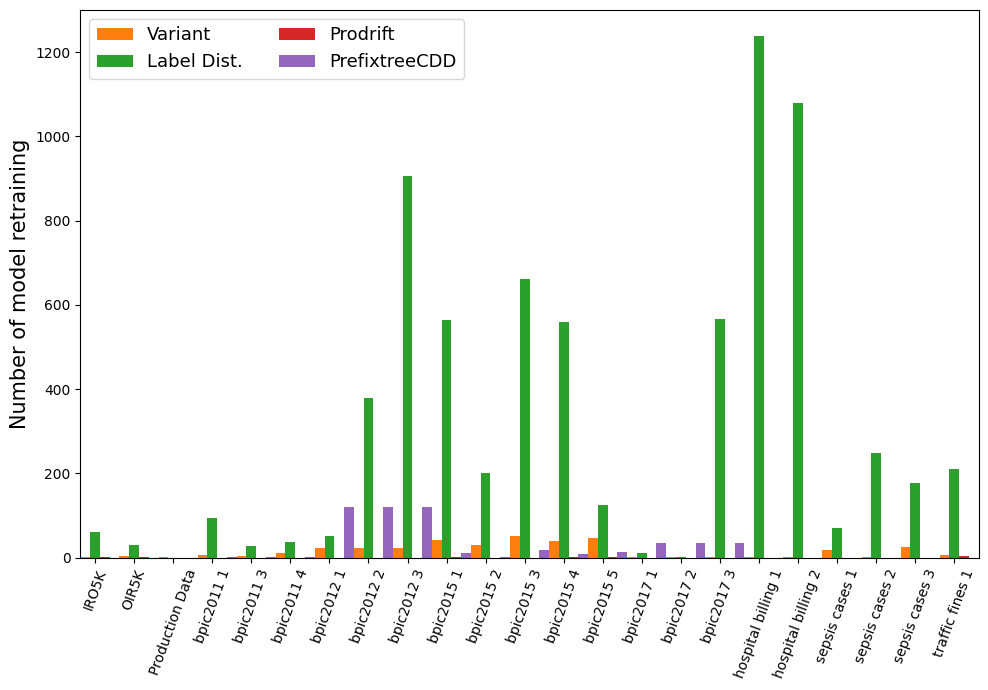

In [25]:
species = ("Adelie", "Chinstrap", "Gentoo")
logs = list(middle_prefix.loc[:, 'Event log'])
logs = [i.replace('_', ' ') for i in logs]

penguin_means = {
    'Variant':  list(middle_prefix.loc[:, 'Variant']),
    'Label Dist.': list(middle_prefix.loc[:, 'Label Dist.']),
    'Prodrift': list(middle_prefix.loc[:, 'Prodrift']),
    'PrefixtreeCDD': list(middle_prefix.loc[:, 'prefixtreeCDD'])
}



x = np.arange(len(logs))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(10, 7)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    print(x + offset)
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = color_map[attribute])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.xaxis.set_tick_params(rotation=70)

ax.set_ylabel('Number of model retraining', fontsize = 15)
# ax.set_title('Frequency of Model Updates Across Event Logs by Triggering Methods', fontsize = 15)
ax.set_xticks(x + width, logs)
ax.legend(loc='upper left', ncols=2, fontsize = 13)
ax.margins(x=0)

fig.tight_layout()
fig.show()
# plt.savefig('../imgs/model_update_frequency.pdf', bbox_inches='tight')

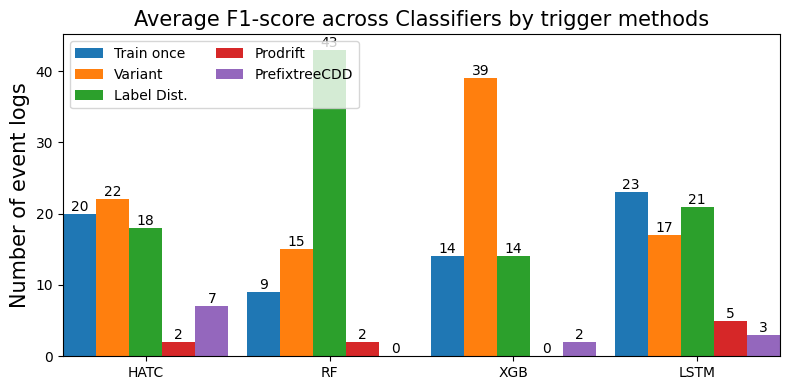

In [27]:
methods = ['Train once', 'Variant',	'Label Dist.', 'Prodrift', 'PrefixtreeCDD']
hatc = [20,22,18,2,7]
rf = [9,15,43,2,0]
xgb = [14,39,14,0,2]
lstm = [23,17,21,5,3]

logs = list(middle_prefix.loc[:, 'Event log'])
logs = [i.replace('_', ' ') for i in logs]
classifiers= ['HATC', 'RF', 'XGB', 'LSTM']
logs = classifiers

penguin_means = {
    'Train once':  [20,9,14,23],
    'Variant':  [22,15,39,17],
    'Label Dist.': [18,43,14,21],
    'Prodrift': [2,2,0,5],
    'PrefixtreeCDD':[7,0,2,3] 
}



x = np.arange(len(logs))  # the label locations
width = 0.18  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(8, 4)
color_map = {}

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    color_map[attribute] = rects[0].get_facecolor()
    # ax.bar_label(rects, padding=3)
    multiplier += 1
    ax.bar_label(rects)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.xaxis.set_tick_params()

ax.set_ylabel('Number of event logs', fontsize = 15)
ax.set_title('Average F1-score across Classifiers by trigger methods', fontsize = 15)
ax.set_xticks([0.36, 1.36, 2.36, 3.36], logs)
ax.legend(loc='upper left', ncols=2)


ax.margins(x=0)

fig.tight_layout()
fig.show()
# plt.savefig('../imgs/model_update_frequency.pdf', bbox_inches='tight')

[0.18 1.18 2.18 3.18]


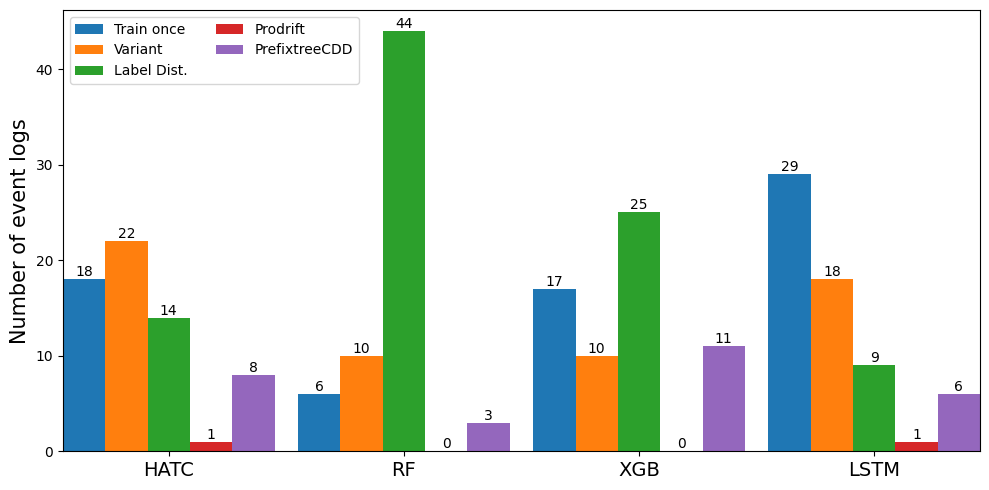

In [33]:
methods = ['Train once', 'Variant',	'Label Dist.', 'Prodrift', 'PrefixtreeCDD']
hatc = [18, 22, 14, 1, 8]
rf = [6,10,44,0,3]
xgb = [17,10,25,0,11]
lstm = [29,18,9,1,6]


logs = list(middle_prefix.loc[:, 'Event log'])
logs = [i.replace('_', ' ') for i in logs]
classifiers= ['HATC', 'RF', 'XGB', 'LSTM']
logs = classifiers

penguin_means = {
    'Train once':   [18, 6,17,29],
    'Variant':      [22,10,10,18],
    'Label Dist.':  [14,44,25,9],
    'Prodrift':     [1,  0, 0, 1],
    'PrefixtreeCDD':[8,  3,11, 6] 
}



x = np.arange(len(logs))  # the label locations
width = 0.18  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(10, 5)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1
    ax.bar_label(rects)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.xaxis.set_tick_params()

ax.set_ylabel('Number of event logs', fontsize = 15)
# ax.set_title('Number of Real-Life Event Logs Where Each Trigger Method \n Achieves the Best Accuracy by Classifier', fontsize = 15)
ax.set_xticks([0.36, 1.36, 2.36, 3.36], logs, fontsize = 14)
ax.legend(loc='upper left', ncols=2)
print(x + width)

ax.margins(x=0)

fig.tight_layout()
# fig.show()
plt.savefig('../imgs/acc_comparison_reallife.pdf', bbox_inches='tight')

[0.18 1.18 2.18 3.18]


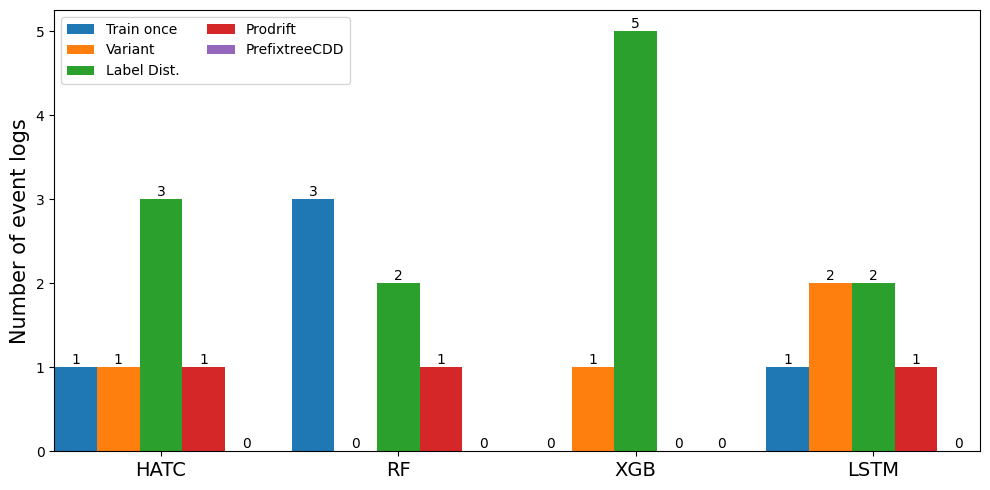

In [36]:
methods = ['Train once', 'Variant',	'Label Dist.', 'Prodrift', 'PrefixtreeCDD']
hatc = [1,1,3,1,0]
rf = [3,0,2,1,0]
xgb =[0,1,5,0,0]
lstm = [1,2,2,1,0]

logs = list(middle_prefix.loc[:, 'Event log'])
logs = [i.replace('_', ' ') for i in logs]
classifiers= ['HATC', 'RF', 'XGB', 'LSTM']
logs = classifiers

penguin_means = {
    'Train once':   [1, 3, 0, 1],
    'Variant':      [1, 0, 1, 2],
    'Label Dist.':  [3, 2, 5, 2],
    'Prodrift':     [1, 1, 0, 1],
    'PrefixtreeCDD':[0, 0, 0, 0] 
}



x = np.arange(len(logs))  # the label locations
width = 0.18  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(10, 5)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1
    ax.bar_label(rects)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.xaxis.set_tick_params()

ax.set_ylabel('Number of event logs', fontsize = 15)
# ax.set_title('Number of Synthetic Event Logs Where Each Trigger Method \n Achieves the Best Accuracy by Classifier', fontsize = 15)
ax.set_xticks([0.36, 1.36, 2.36, 3.36], logs, fontsize = 14)
ax.legend(loc='upper left', ncols=2)
print(x + width)

ax.margins(x=0)

fig.tight_layout()
# fig.show()
plt.savefig('../imgs/acc_comparison_synthetic.pdf', bbox_inches='tight')